In [1]:
import sys
sys.path.append('../../..')

In [2]:
import matplotlib.pyplot as plt
import torch

from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm

from rnn import RNN
from CustomDL.loops.regression import train_loop, test_loop

torch.manual_seed(0)

# Setup

In [3]:
def run_epochs(
    epochs,
    model, loss_fn, optimizer,
    train_loader, test_loader,
    use_gpu: bool = False
) -> dict:
    loss = {
        'train': [],
        'eval': []
    }
    for epoch in range(1, epochs + 1):
        print(f"{epoch}/{epochs}")
        train_loss = train_loop(
            model, train_loader,
            loss_fn, optimizer, True,
            use_gpu=use_gpu
        )
        loss['train'].append(sum(train_loss) / len(train_loss))
        print(f"  Average Training Loss: {loss['train'][-1]:.6f}")

        eval_loss = test_loop(
            model, test_loader, loss_fn,
            use_gpu=use_gpu
        )
        loss['eval'].append(eval_loss)
        print(f"  Average Eval Loss: {loss['eval'][-1]:.6f}")
    
    return loss

# Synthesizing Sequential Data

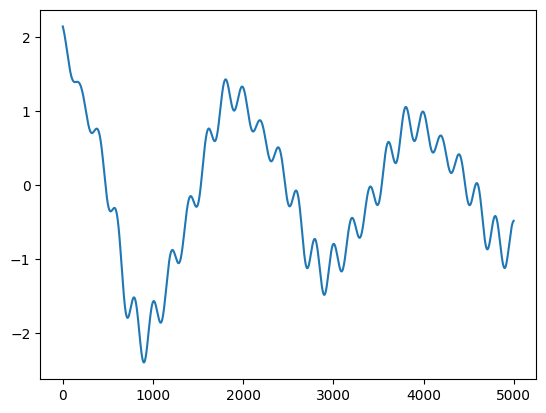

In [3]:
sampling_rate = 1000
total_secs = 5
delta = total_secs / (sampling_rate * total_secs)

x = torch.linspace(0, total_secs, sampling_rate * total_secs)
wave = lambda x: torch.cos(torch.pi * x) / (x + 2) + 0.05 * torch.cos(2 * torch.pi * x * 5)
data = (5 * wave(x) -
    torch.sin(2 * torch.pi * (x - delta)) * wave(x - delta) -
    2 * wave(x - 2 * delta) ** 2
    # + .5 * wave(x - 3 * delta) ** 2
)

plt.plot(data);

In [4]:
class WaveDataset(Dataset):
    def __init__(self,
        wave: torch.Tensor,
        lag_duration: int
    ):
        super().__init__()
        self._wave = wave.unsqueeze(1)
        self._lag_dur = lag_duration
        self._total_seq = self._wave.shape[0] - self._lag_dur
    
    def __len__(self) -> int:
        return self._total_seq
    def __getitem__(self, index):
        if index < 0:
            raise IndexError("Only support non-negative index")
        elif index > len(self):
            raise IndexError(f"Index out of range for length {len(self)}")
        return (
            self._wave[index : index + self._lag_dur],
            self._wave[index + self._lag_dur]
        )

In [5]:
dataset = WaveDataset(data, 3)

train_idx = torch.arange(0, len(dataset) * .8, dtype=torch.int32)
test_idx = torch.arange(train_idx[-1] + 1, len(dataset))

train_set = Subset(dataset, train_idx)
test_set = Subset(dataset, test_idx)

In [6]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size, True)
test_loader = DataLoader(test_set, batch_size, True)

# Predicting the curve

## Training

Let's build a simple MLP model to predict the sequential data. Because the model be given dimensions to initialize the weights and biases, we will let the lag duration be 3. That is, the model will be given ahead three observations to predict the next sample. 

In [9]:
mlp_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)
if torch.cuda.is_available():
    mlp_model.cuda()

mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), 1e-5)

global_loss = {
    'train': [],
    'eval': []
}

In [14]:
loss = run_epochs(
    10, mlp_model, mse_loss,
    optimizer, train_loader, test_loader,
    torch.cuda.is_available()
)

global_loss['train'].extend(loss['train'])
global_loss['eval'].extend(loss['eval'])

1/10


100%|██████████| 125/125 [00:01<00:00, 77.31it/s, loss=0.00016515093739144504] 


  Average Training Loss: 0.000318
  Average Eval Loss: 0.000314
2/10


100%|██████████| 125/125 [00:00<00:00, 144.21it/s, loss=0.0003500095917843282] 


  Average Training Loss: 0.000303
  Average Eval Loss: 0.000294
3/10


100%|██████████| 125/125 [00:00<00:00, 170.19it/s, loss=0.00022278759570326656]


  Average Training Loss: 0.000290
  Average Eval Loss: 0.000278
4/10


100%|██████████| 125/125 [00:00<00:00, 140.14it/s, loss=0.0002821128291543573] 


  Average Training Loss: 0.000278
  Average Eval Loss: 0.000266
5/10


100%|██████████| 125/125 [00:00<00:00, 167.44it/s, loss=0.00023384574160445482]


  Average Training Loss: 0.000268
  Average Eval Loss: 0.000262
6/10


100%|██████████| 125/125 [00:00<00:00, 168.24it/s, loss=0.0002226276119472459] 


  Average Training Loss: 0.000258
  Average Eval Loss: 0.000255
7/10


100%|██████████| 125/125 [00:00<00:00, 167.84it/s, loss=0.00026958619127981365]


  Average Training Loss: 0.000250
  Average Eval Loss: 0.000248
8/10


100%|██████████| 125/125 [00:00<00:00, 180.81it/s, loss=0.0002474566572345793] 


  Average Training Loss: 0.000243
  Average Eval Loss: 0.000244
9/10


100%|██████████| 125/125 [00:00<00:00, 172.26it/s, loss=0.00019324653840158135]


  Average Training Loss: 0.000237
  Average Eval Loss: 0.000236
10/10


100%|██████████| 125/125 [00:00<00:00, 181.70it/s, loss=0.00021723903773818165]


  Average Training Loss: 0.000232
  Average Eval Loss: 0.000235


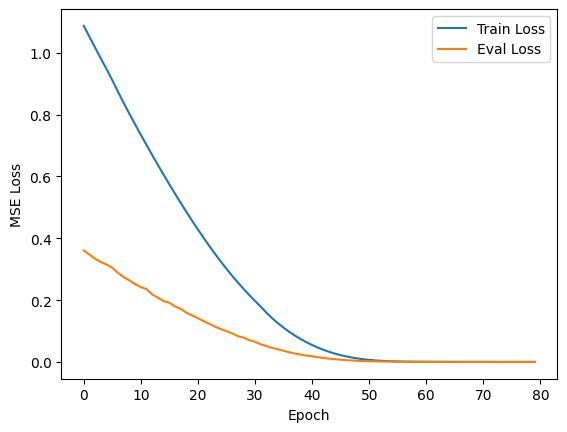

In [15]:
plt.plot(global_loss['train'], label='Train Loss')
plt.plot(global_loss['eval'], label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend();

In [16]:
checkpoint = {
    'model': mlp_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss': global_loss
}

torch.save(checkpoint, '../output/mlp_wave.tar')

## Inference

In [34]:
mlp_model.eval()
pred = []

with torch.no_grad():
    for X, _ in tqdm(DataLoader(dataset, batch_size, False)):
        if torch.cuda.is_available():
            X = X.cuda()
        pred.append(mlp_model(X).cpu())
pred = torch.concat(pred).squeeze()

100%|██████████| 157/157 [00:01<00:00, 150.18it/s]


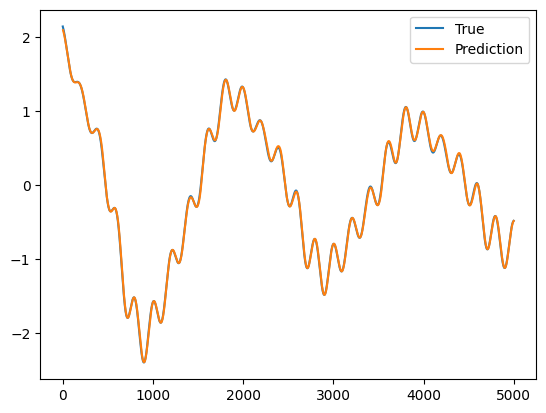

In [ ]:
plt.plot(data, label='Ground Truth')
plt.plot(list(range(3, data.shape[0])), pred, label="Prediction")
plt.legend();

Our model performs great with the three observations we have given it. This is relatively trivial as our function contains information on the current sample, the previous sample and the sample before that.

However, what happens if say we only have the previous observation? What about fine-tuning our model on a different distribution that require more than 3 past observations? All of this require our model to be flexible in terms of the input's dimension.

This is something that the RNN can solve.

# The Recurrent Network
The idea here is, instead of scaling the width of our hidden layers by the lag duration, we fix the hidden layer's dimension and use that layer for all past observations.

Here we will use the Elmann's recurrent network to do this. The Elmann's network specifies two sets of weights and biases. The first set of weights and biases is for encoding the input, let us call this `w_in_hidden`. The second set of weights and biases is for encoding the previous hidden states, let us call this `w_hidden_hidden`.

When the network receives an input sequence of data, the first element of the sequence is fed through the network using `w_in_hidden` and activated with some arbitrary function. The output of this is called the hidden state. Then, the second element of the sequence is fed through the network the same way, along with the hidden state obtained previously. Then, the result of this is summed and activated with the same function to obtained the next hidden state. This continues until the whole sequence is fed through the network, at which point the last hidden state will contain information about the sequence.

## Training

In [10]:
class RNNRegressor(nn.Module):
    def __init__(self,
        in_features: int,
        out_features: int,
        hidden_size: int,
        activation_fn: None | nn.Module=None
    ):
        super().__init__()
        self.rnn = RNN(in_features, hidden_size, activation_fn)
        self.linear = nn.Linear(hidden_size, out_features)
    
    def forward(self, seq, hidden_state=None):
        out, _ = self.rnn(seq, hidden_state)
        return self.linear(out[:, -1, :])

In [25]:
rnn_model = RNNRegressor(1, 1, 32, nn.ReLU())
if torch.cuda.is_available():
    rnn_model.cuda()

mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), 1e-5)

global_loss = {
    'train': [],
    'eval': []
}

In [33]:
loss = run_epochs(
    10, rnn_model, mse_loss,
    optimizer, train_loader, test_loader,
    torch.cuda.is_available()
)

global_loss['train'].extend(loss['train'])
global_loss['eval'].extend(loss['eval'])

1/10


100%|██████████| 125/125 [00:00<00:00, 127.99it/s, loss=0.0032304651103913784] 


  Average Training Loss: 0.001958
  Average Eval Loss: 0.000444
2/10


100%|██████████| 125/125 [00:00<00:00, 139.90it/s, loss=0.0006002401350997388] 


  Average Training Loss: 0.001804
  Average Eval Loss: 0.000425
3/10


100%|██████████| 125/125 [00:00<00:00, 139.52it/s, loss=0.000586853944696486]  


  Average Training Loss: 0.001662
  Average Eval Loss: 0.000398
4/10


100%|██████████| 125/125 [00:00<00:00, 142.00it/s, loss=0.0023779573384672403] 


  Average Training Loss: 0.001533
  Average Eval Loss: 0.000373
5/10


100%|██████████| 125/125 [00:00<00:00, 151.15it/s, loss=0.0004966594860889018] 


  Average Training Loss: 0.001410
  Average Eval Loss: 0.000351
6/10


100%|██████████| 125/125 [00:00<00:00, 148.94it/s, loss=0.0025881417095661163] 


  Average Training Loss: 0.001299
  Average Eval Loss: 0.000322
7/10


100%|██████████| 125/125 [00:00<00:00, 154.49it/s, loss=0.0028661228716373444] 


  Average Training Loss: 0.001193
  Average Eval Loss: 0.000327
8/10


100%|██████████| 125/125 [00:00<00:00, 151.49it/s, loss=0.0005111315986141562] 


  Average Training Loss: 0.001096
  Average Eval Loss: 0.000300
9/10


100%|██████████| 125/125 [00:00<00:00, 155.02it/s, loss=0.0003368798934388906] 


  Average Training Loss: 0.001008
  Average Eval Loss: 0.000279
10/10


100%|██████████| 125/125 [00:00<00:00, 149.42it/s, loss=0.00021508827921934426]


  Average Training Loss: 0.000927
  Average Eval Loss: 0.000285


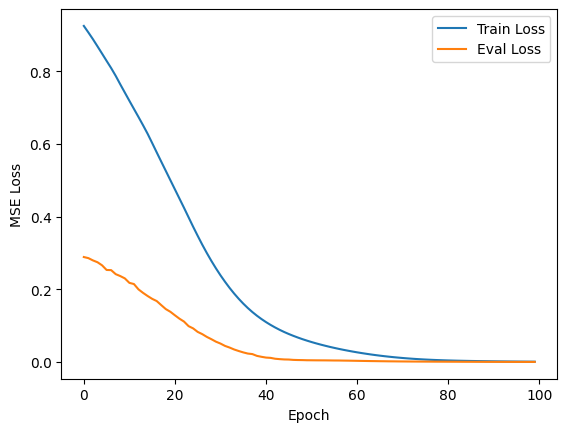

In [34]:
plt.plot(global_loss['train'], label='Train Loss')
plt.plot(global_loss['eval'], label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend();

In [35]:
checkpoint = {
    'model': rnn_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss': global_loss
}

torch.save(checkpoint, '../output/rnn_wave.tar')

## Inference

In [17]:
rnn_model.eval()
pred = []

with torch.no_grad():
    for X, _ in tqdm(DataLoader(dataset, batch_size, False)):
        if torch.cuda.is_available():
            X = X.cuda()
        pred.append(rnn_model(X).cpu())
pred = torch.concat(pred).squeeze()

100%|██████████| 157/157 [00:00<00:00, 770.54it/s]


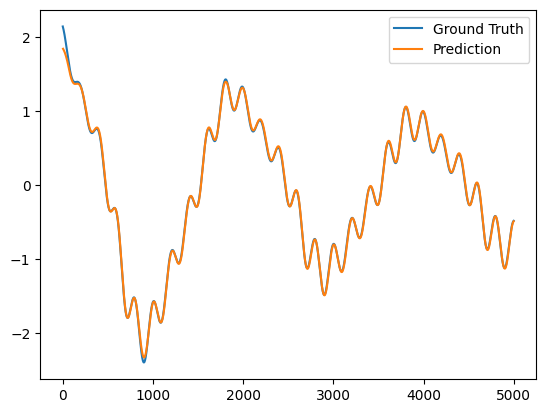

In [18]:
plt.plot(data, label='Ground Truth')
plt.plot(list(range(3, data.shape[0])), pred, label="Prediction")
plt.legend();

Just like the MLP, this model can fit just as well. However, with this model, we can now predict on a variable amount of input sequences.

# Inference with different lag

In [34]:
lags = [WaveDataset(data, i) for i in range(2, 6)]

with torch.no_grad():
    pred = [
        torch.concat([
            rnn_model(X.cuda() if torch.cuda.is_available() else X).cpu()
            for X, _ in tqdm(DataLoader(lag, batch_size, False), desc=f'Lag duration: {lag._lag_dur}')
        ])
        for lag in lags
    ]

Lag duration: 5: 100%|██████████| 157/157 [00:00<00:00, 656.63it/s]


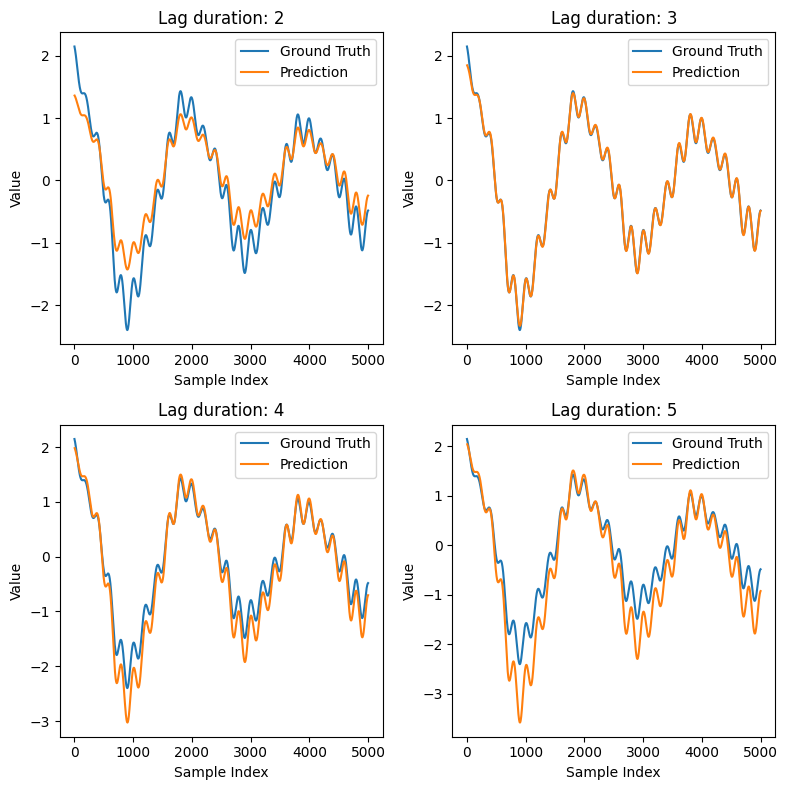

In [41]:
fig = plt.figure(figsize=(8, 8))
axes = fig.subplot_mosaic([[2, 3], [4, 5]])

for i in range(2, 6):
    axes[i].plot(data, label='Ground Truth')
    axes[i].plot(list(range(i, data.shape[0])), pred[i - 2], label="Prediction")

    axes[i].set_title(f"Lag duration: {i}")
    axes[i].set_xlabel('Sample Index')
    axes[i].set_ylabel('Value')
    axes[i].legend()
fig.tight_layout()

As you can see, our model does its best on lag duration of 3. However, with other lag duration, it can predict some periods quite well, and definitely can identify the general trend of the data.